Many image processing libraries and frameworks actually implement cross-correlation when they say "convolution".
This is because for symmetric filters (like Gaussian filters), convolution and cross-correlation give identical results.
For asymmetric filters, you might need to be careful about which operation you're actually using.

When you do true convolution with an impulse:

1. You first flip the filter (both horizontally and vertically)
1. Then slide it over the impulse
1. Because of the mathematical properties of convolution with an impulse, the result you get is the original filter (not the flipped version)


If you did cross-correlation with an impulse:

1. You'd slide the filter directly (no flipping)
1. The result would be the flipped version of the filter

Cross-correlation is when you directly slide the filter over the image, multiplying and summing. The operation looks like this:
$$
(f \cdot g)[n] = \sum f[m] \times g[m+n]
$$

Convolution is similar but involves flipping the filter (both horizontally and vertically) first:
$$
(f \star g)[n] = \sum f[m] \times g[n-m]
$$

In [1]:
import numpy as np
import scipy

In [2]:
_identity = np.identity(3)
_identity

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [3]:
# Flip along the vertical axis (axis=0).
# axis=1 is a flip along the horizontal axis.
np.flip(_identity), np.flip(_identity, axis=0), np.flip(_identity, axis=1)

(array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]),
 array([[0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.]]),
 array([[0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.]]))

In [4]:
_reverse_identity = np.flip(_identity, axis=0)
_reverse_identity

array([[0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.]])

In [5]:
# The transpose of the reverse identity is itself.
_reverse_identity.T

array([[0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.]])

In [6]:
# The transpose of the identity is itself.
_identity.T

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [7]:
img_filter = np.array(
    [
        [0, 1, 2],
        [3, 4, 5],
        [6, 7, 8],
    ]
)
img_filter, img_filter.shape, img_filter.dtype

(array([[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]]),
 (3, 3),
 dtype('int64'))

In [8]:
# Vertical flip.
np.matmul(_reverse_identity, img_filter)

array([[6., 7., 8.],
       [3., 4., 5.],
       [0., 1., 2.]])

In [9]:
# Vertical flip.
# Same as above but using the more convenient notation.
_reverse_identity.T @ img_filter

array([[6., 7., 8.],
       [3., 4., 5.],
       [0., 1., 2.]])

In [10]:
# Horizontal flip!!!
img_filter @ _reverse_identity

array([[2., 1., 0.],
       [5., 4., 3.],
       [8., 7., 6.]])

In [11]:
# Double flip!!!
_reverse_identity.T @ img_filter @ _reverse_identity

array([[8., 7., 6.],
       [5., 4., 3.],
       [2., 1., 0.]])

In [12]:
_impulse_img = scipy.signal.unit_impulse((3, 3), 'mid')
_impulse_img

array([[0., 0., 0.],
       [0., 1., 0.],
       [0., 0., 0.]])

In [13]:
_convolve = _reverse_identity.T @ img_filter @ _reverse_identity
_convolve

array([[8., 7., 6.],
       [5., 4., 3.],
       [2., 1., 0.]])

In [14]:
# The convention in image processing/computer vision is typically:
# First argument is considered the "image" or "signal".
# Second argument is considered the "kernel" or "filter".
# First img_filter gets double flipped and then it does correlation.
scipy.signal.convolve(_impulse_img, img_filter)

array([[0., 0., 0., 0., 0.],
       [0., 0., 1., 2., 0.],
       [0., 3., 4., 5., 0.],
       [0., 6., 7., 8., 0.],
       [0., 0., 0., 0., 0.]])

In [15]:
# See!
# Here we manually did the double flipping of the filter before doing the correlation step
# ourselves.
scipy.signal.correlate(_impulse_img, _convolve)

array([[0., 0., 0., 0., 0.],
       [0., 0., 1., 2., 0.],
       [0., 3., 4., 5., 0.],
       [0., 6., 7., 8., 0.],
       [0., 0., 0., 0., 0.]])

In [16]:
# And just for kicks...
scipy.signal.convolve(_impulse_img, _convolve)

array([[0., 0., 0., 0., 0.],
       [0., 8., 7., 6., 0.],
       [0., 5., 4., 3., 0.],
       [0., 2., 1., 0., 0.],
       [0., 0., 0., 0., 0.]])

## Manual Cross-Correlation

In [17]:
"""
4x4 input:        Possible 2x2 kernel positions:
[ ][ ][ ][ ]      [K][K][ ][ ]     [ ][K][K][ ]     [ ][ ][K][K]
[ ][ ][ ][ ]      [K][K][ ][ ]     [ ][K][K][ ]     [ ][ ][K][K]
[ ][ ][ ][ ]      [ ][ ][ ][ ]     [ ][ ][ ][ ]     [ ][ ][ ][ ]
[ ][ ][ ][ ]      [ ][ ][ ][ ]     [ ][ ][ ][ ]     [ ][ ][ ][ ]

                  [ ][ ][ ][ ]      [ ][ ][ ][ ]     [ ][ ][ ][ ]
                  [K][K][ ][ ]      [ ][K][K][ ]     [ ][ ][K][K]
                  [K][K][ ][ ]      [ ][K][K][ ]     [ ][ ][K][K]
                  [ ][ ][ ][ ]      [ ][ ][ ][ ]     [ ][ ][ ][ ]

                  [ ][ ][ ][ ]      [ ][ ][ ][ ]     [ ][ ][ ][ ]
                  [ ][ ][ ][ ]      [ ][ ][ ][ ]     [ ][ ][ ][ ]
                  [K][K][ ][ ]      [ ][K][K][ ]     [ ][ ][K][K]
                  [K][K][ ][ ]      [ ][K][K][ ]     [ ][ ][K][K]
"""
# Manual correlation.
# Create a simple 4x4 "image".
image = np.array([
    [1,  2,  3,  4],
    [5,  6,  7,  8],
    [9,  10, 11, 12],
    [13, 14, 15, 16]
])

# Create a 2x2 kernel.
kernel = np.identity(2)

# Output will be 3x3 due to kernel size.
# output_size = input_size - kernel_size + 1 -> 4 - 2 + 1 = 3.
result = np.zeros((3, 3))

for i in range(3):
    for j in range(3):
        # For each position, multiply kernel with corresponding image region.
        # This (the following op, not the op + the np.sum()) is the Hadamard product,
        # element-wise multiplication, not matrix multiplication.
        region = image[i:i+2, j:j+2]
        value = np.sum(region * kernel)
        result[i, j] = value

result

array([[ 7.,  9., 11.],
       [15., 17., 19.],
       [23., 25., 27.]])

In [18]:
"""
Hadamard product:
[[1, 2],     [[1, 0],     [[1*1, 2*0],     [[1, 0],
 [5, 6]]  *   [0, 1]]  =   [5*0, 6*1]]  =  [0, 6]]
"""
# First is Hadamard product.
# Second is the matmul.
image[0:2, 0:2] * kernel, image[0:2, 0:2] @ kernel

(array([[1., 0.],
        [0., 6.]]),
 array([[1., 2.],
        [5., 6.]]))

In [19]:
# The default mode will take into account the boundary conditions.
scipy.signal.correlate(image, kernel, mode='valid'), scipy.signal.correlate(image, kernel, mode='full')

(array([[ 7.,  9., 11.],
        [15., 17., 19.],
        [23., 25., 27.]]),
 array([[ 1.,  2.,  3.,  4.,  0.],
        [ 5.,  7.,  9., 11.,  4.],
        [ 9., 15., 17., 19.,  8.],
        [13., 23., 25., 27., 12.],
        [ 0., 13., 14., 15., 16.]]))

## Complex Plane

In [20]:
_matrix = np.matrix(
    [
        [1+2j, 3-1j],
        [0+3j, 4+6j],
    ],
)
_matrix

matrix([[1.+2.j, 3.-1.j],
        [0.+3.j, 4.+6.j]])

In [21]:
_matrix.T

matrix([[1.+2.j, 0.+3.j],
        [3.-1.j, 4.+6.j]])

In [22]:
_matrix.T.conj()

matrix([[1.-2.j, 0.-3.j],
        [3.+1.j, 4.-6.j]])

In [23]:
_matrix.H

matrix([[1.-2.j, 0.-3.j],
        [3.+1.j, 4.-6.j]])

In [24]:
_impulse_img = scipy.signal.unit_impulse((2, 2), 'mid')

In [25]:
scipy.signal.convolve(_impulse_img, _matrix)

array([[0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+2.j, 3.-1.j],
       [0.+0.j, 0.+3.j, 4.+6.j]])

In [26]:
scipy.signal.correlate(_impulse_img, _matrix)

array([[0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 4.-6.j, 0.-3.j],
       [0.+0.j, 3.+1.j, 1.-2.j]])

# Normalized Cross-Correlations

In [27]:
_signal = np.array([1, 2, 3, 4, 5, 6, 7, 8])
_template = np.array([2, 3])

"""
Position 0: (1×2 + 2×3) = 8     # [1,2] × [2,3]
Position 1: (2×2 + 3×3) = 13    # [2,3] × [2,3]  <- This is where template actually matches!
Position 2: (3×2 + 4×3) = 18    # [3,4] × [2,3]
Position 3: (4×2 + 5×3) = 23    # [4,5] × [2,3]
...and so on
"""
correlation = scipy.signal.correlate(_signal, _template, mode='valid')
correlation

array([ 8, 13, 18, 23, 28, 33, 38])

In [28]:
np.argmax(correlation), _signal[np.argmax(correlation)]

(np.int64(6), np.int64(7))

In [29]:
np.dot(_template, _template)

np.int64(13)

In [30]:
# In order to find a match when the correlation is not normalized then we ought to look for it
# based on what it should look like.
np.where(np.dot(_template, _template) == correlation)

(array([1]),)

In [31]:
_signal = np.array([1, 1, 0, 1, 0, 0, -1, -1, 1])
_template = np.array([0, 1, 0])

correlation = scipy.signal.correlate(_signal, _template, mode='valid')
correlation

array([ 1,  0,  1,  0,  0, -1, -1])

In [32]:
_signal = np.array([1, 2, 3, 4, 5, 6, 7, 8])
_template = np.array([2, 3])

corr = scipy.signal.correlate(_signal, _template, mode='valid')

"""
When normalizing correlation, you want to normalize each window independently against the template.
The proper way is your first example:

For each window of the signal (same length as template):

Compute norm of that window
Compute norm of template
Divide correlation value by (window_norm * template_norm)

when sliding the template across the signal, each position needs its own normalization based
on the values in that specific window.
"""
template_norm = np.linalg.norm(_template) # Same as np.sqrt( np.sum(np.square(_template)))
windows = np.lib.stride_tricks.sliding_window_view(_signal, _template.size)
window_norms = np.linalg.norm(windows, axis=1) # Same as np.sqrt(np.sum(np.square(windows), axis=1))
normalized_corr = corr / (window_norms * template_norm)
normalized_corr

array([0.99227788, 1.        , 0.99846035, 0.99624059, 0.99430915,
       0.99273378, 0.9914543 ])

In [33]:
# As we saw above, the cross correlation is done by sliding the filter over the signal.
# Turns out there is a function for that!
windows = np.lib.stride_tricks.sliding_window_view(_signal, 2)
windows

array([[1, 2],
       [2, 3],
       [3, 4],
       [4, 5],
       [5, 6],
       [6, 7],
       [7, 8]])

In [34]:
np.square(windows), np.sum(np.square(windows), axis=1), np.sqrt( np.sum(np.square(windows), axis=1) )

(array([[ 1,  4],
        [ 4,  9],
        [ 9, 16],
        [16, 25],
        [25, 36],
        [36, 49],
        [49, 64]]),
 array([  5,  13,  25,  41,  61,  85, 113]),
 array([ 2.23606798,  3.60555128,  5.        ,  6.40312424,  7.81024968,
         9.21954446, 10.63014581]))

In [35]:
# We want the norm over axis=1.
# When you pass axis=1, you are telling np.linalg.norm to compute the norm along the second dimension (columns)
# for each row.
# Thus, passing axis=0 will compute the norm along the rows for each column.
np.linalg.norm(windows, axis=1), np.linalg.norm(windows, axis=0)

(array([ 2.23606798,  3.60555128,  5.        ,  6.40312424,  7.81024968,
         9.21954446, 10.63014581]),
 array([11.83215957, 14.24780685]))

In [36]:
template_norm = np.sqrt( np.sum(np.square(_template)))
template_norm, np.linalg.norm(_template)

(np.float64(3.605551275463989), np.float64(3.605551275463989))

In [37]:
def normalized_cross_correlation(signal, signal_filter):
    """
    When normalizing correlation, you want to normalize each window independently against the template.
    The proper way is your first example:
    
    For each window of the signal (same length as template):
    
    1. Compute norm of that window
    2. Compute norm of template
    3. Divide correlation value by (window_norm * template_norm)
    
    when sliding the template across the signal, each position needs its own normalization based
    on the values in that specific window.
    """
    correlation = scipy.signal.correlate(signal, signal_filter, mode='valid')

    windows = np.lib.stride_tricks.sliding_window_view(signal, signal_filter.size)
    window_norms = np.linalg.norm(windows, axis=1) # Same as np.sqrt(np.sum(np.square(windows), axis=1))

    filter_norm = np.linalg.norm(signal_filter) # Same as np.sqrt( np.sum(np.square(_template)))
    
    return correlation / (window_norms * filter_norm)

In [38]:
signal = np.array([1, -1, 0, 1, 1, 1, 0, -1, -1, -1, 1, 0, 0, -1, 1, 1, 0, 1, 1, 0])
signal_filter = np.array([1, 1, 0])

norm_corr = normalized_cross_correlation(signal, signal_filter)
norm_corr, norm_corr.shape

(array([ 0.        , -0.5       ,  0.5       ,  0.81649658,  1.        ,
         0.5       , -0.5       , -0.81649658, -0.81649658,  0.        ,
         0.70710678,  0.        , -0.5       ,  0.        ,  1.        ,
         0.5       ,  0.5       ,  1.        ]),
 (18,))

In [39]:
max_idx = int(np.argmax(norm_corr))
max_idx

4

In [40]:
signal[max_idx:max_idx+3]

array([1, 1, 0])

In [41]:
1e-3

0.001

In [42]:
matches = np.where(np.isclose(norm_corr, norm_corr[max_idx], rtol=1e-3))
matches = matches[0]

In [43]:
for idx in matches:
    print(f'idx: {idx:2d} : {signal[idx:idx+3]}')

idx:  4 : [1 1 0]
idx: 14 : [1 1 0]
idx: 17 : [1 1 0]


In [44]:
def normalized_cross_correlation_full(signal, signal_filter):
    correlation = scipy.signal.correlate(signal, signal_filter, mode='full')
    
    # For full correlation, we need to pad the signal to handle edge cases.
    pad_width = signal_filter.size - 1
    padded_signal = np.pad(signal, pad_width)
    
    # Get windows for the entire padded signal.
    windows = np.lib.stride_tricks.sliding_window_view(padded_signal, signal_filter.size)
    
    # Compute norms for all windows.
    window_norms = np.linalg.norm(windows, axis=1)
    
    # Compute template norm.
    filter_norm = np.linalg.norm(signal_filter)
    
    # Avoid division by zero.
    eps = np.finfo(float).eps
    denominator = window_norms * filter_norm
    denominator = np.where(denominator > eps, denominator, eps)
    
    return correlation / denominator

In [45]:
signal = np.array([-1, 0, 0, 1, 1, 1, 0, -1, -1, 0, 1, 0, 0, -1])
signal_filter = np.array([1, 1, 0])

norm_corr = normalized_cross_correlation_full(signal, signal_filter)
norm_corr, norm_corr.shape

(array([ 0.        , -0.70710678, -0.70710678,  0.        ,  0.5       ,
         0.81649658,  1.        ,  0.5       , -0.5       , -1.        ,
        -0.5       ,  0.70710678,  0.70710678,  0.        , -0.70710678,
        -0.70710678]),
 (16,))

In [46]:
signal.size, norm_corr.size

(14, 16)

In [47]:
max_idx = int(np.argmax(norm_corr))
matches = np.where(np.isclose(norm_corr, norm_corr[max_idx], rtol=1e-3))
matches = matches[0]
for idx in matches:
    print(f'idx: {idx:2d} : {signal[idx:idx+3]}')

idx:  6 : [ 0 -1 -1]


# Template Matching

In [48]:
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib import gridspec
import ipywidgets as widgets
import requests
from pathlib import Path

from tqdm.notebook import tqdm

In [49]:
from dataclasses import dataclass
import shutil

@dataclass
class ImageInfo:
    image_path: Path
    url: str
    img: cv.Mat|None = None

    def download(self) -> cv.Mat:
        img_data = requests.get(self.url).content
        with open(self.image_path, 'wb') as f:
            f.write(img_data)
    
        # Opencv reads images in BGR.
        self.img = cv.imread(self.image_path)

    def rgb(self) -> cv.Mat:
        return cv.cvtColor(self.img, cv.COLOR_BGR2RGB)


class ImageCache:
    def __init__(self, base_path: str = './img/003-images'):
        self._base_path = Path(base_path)
        self._base_path.mkdir(parents=True, exist_ok=True)
        
        self._cache: dict[str, ImageInfo] = {
            'egyptian': ImageInfo( # https://wired.me/technology/artificial-intelligence/google-translate-for-egyptian-hieroglyphics/
                image_path=self._base_path / 'egyptian.jpg',
                url='https://miro.medium.com/v2/resize:fit:1400/format:webp/1*wL0-RPYJr5OjX9un6UCouA.jpeg',
            )
        }
        for img_key, img in tqdm(self._cache.items(), desc="Downloading images"):
            img.download()

    def images(self):
        """Return all the image names registered."""
        return self._cache.keys()

    def __getitem__(self, img_name: str) -> ImageInfo:
        """Allow dictionary-like access to loaded images."""
        if img_name not in self._cache:
            self.load_img(img_name)
        return self._cache[img_name]

    def clear_cache(self):
        shutil.rmtree(self._base_path)


CACHE = ImageCache()

In [50]:
#CACHE.clear_cache()

In [51]:
import ipywidgets as widgets
from IPython.display import display
from matplotlib.widgets import RectangleSelector

def create_interactive_mask(img: cv.Mat, figsize: tuple = (8, 5)):
    """
    Creates an interactive interface for drawing rectangular masks on an image.
    
    INPUTS
    ------
    img: cv.Mat
        
    RETURNS
    -------
    tuple: (figure, mask, selector) - The matplotlib figure, mask array, and selector object
    """
    # Read and convert image.
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    
    # Create mask as a nonlocal variable so it can be modified in onselect.
    nonlocal_vars = {
        'mask': np.zeros(img.shape[:2], dtype=np.uint8)
    }
    
    # Create the figure and axis.
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5))
    
    def onselect(eclick, erelease):
        """Handle rectangle selection"""
        x1, y1 = int(eclick.xdata), int(eclick.ydata)
        x2, y2 = int(erelease.xdata), int(erelease.ydata)
        
        # Reset mask.
        nonlocal_vars['mask'][:] = 0
        
        # Create rectangle on mask.
        nonlocal_vars['mask'][min(y1, y2):max(y1, y2), min(x1, x2):max(x1, x2)] = 255
        
        # Apply mask to image.
        masked_img = cv.bitwise_and(img_rgb, img_rgb, mask=nonlocal_vars['mask'])
        
        # Update the right plot.
        ax2.clear()
        ax2.imshow(masked_img)
        ax2.set_title('Masked Result')
        plt.draw()
    
    # Setup initial plots.
    ax1.imshow(img_rgb)
    ax1.set_title('Draw rectangle here')
    
    ax2.imshow(img_rgb)
    ax2.set_title('Masked Result')
    
    # Create the rectangle selector.
    selector = RectangleSelector(ax1, onselect, interactive=True)
    
    plt.tight_layout()
    
    return fig, nonlocal_vars['mask'], selector

In [52]:
%matplotlib widget

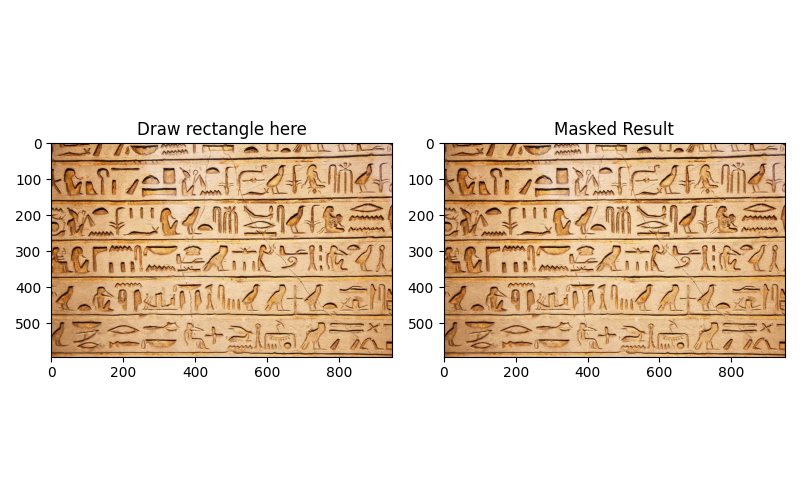

In [53]:
fig, mask, selector = create_interactive_mask(CACHE['egyptian'].img, figsize=(10, 10))
plt.show()

In [54]:
%matplotlib inline

In [55]:
plt.close('all')

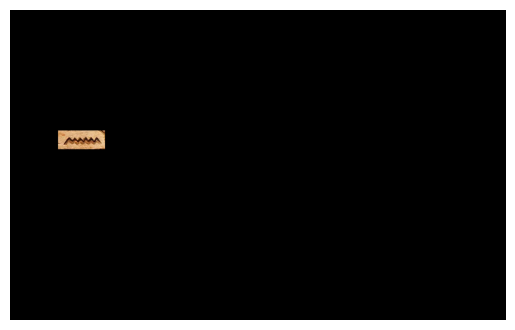

In [56]:
masked_image = cv.bitwise_and(CACHE['egyptian'].img, CACHE['egyptian'].img, mask=mask)
masked_image_rgb = cv.cvtColor(masked_image, cv.COLOR_BGR2RGB)

plt.imshow(masked_image_rgb)
plt.axis('off')    
plt.show()

In [57]:
# Find the bounding rectangle of the mask
x, y, w, h = cv.boundingRect(mask)
x, y, w, h

(92, 232, 90, 36)

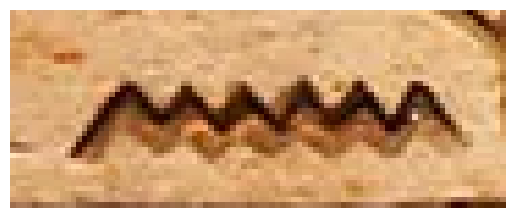

In [58]:
cropped_image = CACHE['egyptian'].img[y:y+h, x:x+w]
cropped_image_rgb = cv.cvtColor(cropped_image, cv.COLOR_BGR2RGB)

plt.imshow(cropped_image_rgb)
plt.axis('off')    
plt.show()

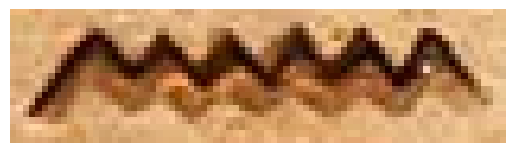

In [73]:
manually_shifted_x = x+8
manually_shifted_y = y+10
cropped_image = CACHE['egyptian'].img[manually_shifted_y:manually_shifted_y+h-15, manually_shifted_x:manually_shifted_x+w-12]
cropped_image_rgb = cv.cvtColor(cropped_image, cv.COLOR_BGR2RGB)

plt.imshow(cropped_image_rgb)
plt.axis('off')    
plt.show()

In [109]:
def visualize_template_matching(img, template, method=cv.TM_CCOEFF_NORMED, threshold=0.5):
    """
    Perform template matching and visualize results

    See https://docs.opencv.org/4.11.0/d4/dc6/tutorial_py_template_matching.html
    
    INPUTS
    ------
    img: Source image (cv2.Mat)
    template: Template to match (cv2.Mat)
    method: Template matching method
    threshold: Threshold for considering a match (for multiple matches)
    """
    # Perform template matching.
    result = cv.matchTemplate(img, template, method)
        
    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum.
    if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
        threshold = 1 - threshold
        locations = np.where(result <= threshold)
    else:
        locations = np.where(result >= threshold)
    
    # Draw rectangles for all matches.
    img_with_rect = img.copy()
    
    # Get dimensions of the template.
    # We will use them to draw the rectangles (sort of trying to overlay the template over the matches).
    h, w = template.shape[:2]
    
    # Locations returns a tuple of arrays (NOT an array of tuples).
    # The * unpacks this tuple of arrays into separate arguments for zip().
    # Without *, zip(locations[::-1]) would try to zip the entire tuple as one argument.
    for pt in zip(*locations[::-1]):  # Switch columns and rows.
        cv.rectangle(img_with_rect, pt, (pt[0] + w, pt[1] + h), (0, 255, 0), 2)
    
    # Convert BGR to RGB for matplotlib.
    # We are doing this now since we definetely just want it for plotting.
    if len(img_with_rect.shape) == 3:
        img_with_rect = cv.cvtColor(img_with_rect, cv.COLOR_BGR2RGB)
    
    return result, img_with_rect

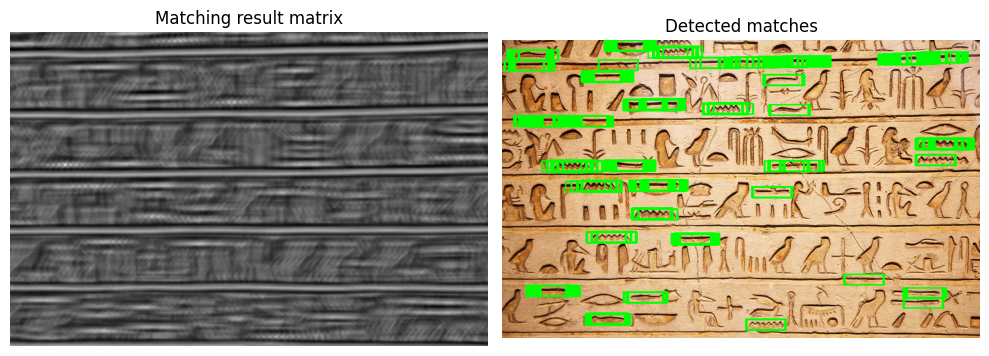

In [110]:
original_img = CACHE['egyptian'].img
template = cropped_image

matched_img, img_with_selections = visualize_template_matching(
    original_img,
    template, 
    method=cv.TM_CCOEFF_NORMED,
    threshold=0.50)

fig = plt.figure(figsize=(10, 6))

# Create grid specification with 1 rows and 2 columns.
gs = gridspec.GridSpec(1, 2, figure=fig)

# Add the subplots
ax1 = fig.add_subplot(gs[0, 0])  # First row, first column.
ax2 = fig.add_subplot(gs[0, 1])  # First row, second column.

ax1.imshow(matched_img, cmap='gray')
ax1.set_title('Matching result matrix')
ax1.axis('off')

ax2.imshow(img_with_selections)
ax2.set_title('Detected matches')
ax2.axis('off')


plt.tight_layout()
plt.show()

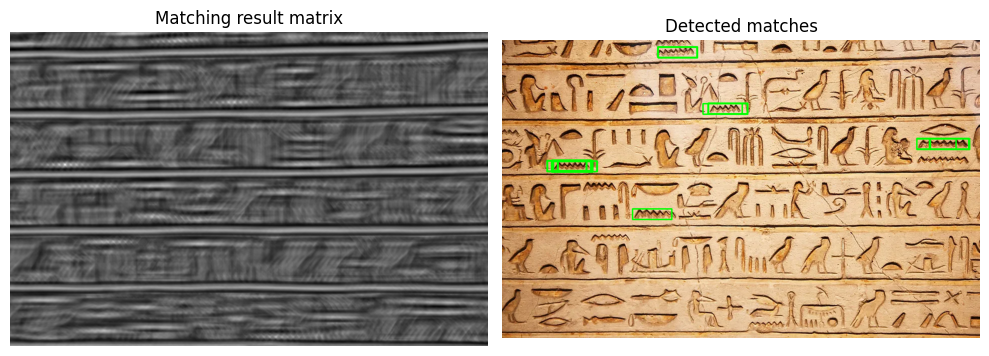

In [111]:
original_img = CACHE['egyptian'].img
template = cropped_image
    
matched_img, img_with_selections = visualize_template_matching(
    original_img,
    template, 
    method=cv.TM_CCOEFF_NORMED,
    threshold=0.6)

fig = plt.figure(figsize=(10, 6))

# Create grid specification with 1 rows and 2 columns.
gs = gridspec.GridSpec(1, 2, figure=fig)

# Add the subplots
ax1 = fig.add_subplot(gs[0, 0])  # First row, first column.
ax2 = fig.add_subplot(gs[0, 1])  # First row, second column.

ax1.imshow(matched_img, cmap='gray')
ax1.set_title('Matching result matrix')
ax1.axis('off')

ax2.imshow(img_with_selections)
ax2.set_title('Detected matches')
ax2.axis('off')


plt.tight_layout()
plt.show()

In [80]:
# Leaving some hints to get some more intuition...
_result = cv.matchTemplate(original_img, template, cv.TM_CCOEFF_NORMED)
_result

array([[ 0.21201105,  0.2295947 ,  0.23889504, ..., -0.12033734,
        -0.11461767, -0.11157202],
       [ 0.13089988,  0.14010595,  0.14638542, ..., -0.01898754,
        -0.01241034, -0.0176372 ],
       [ 0.03019573,  0.03036643,  0.0314103 , ...,  0.06058253,
         0.06908134,  0.07036575],
       ...,
       [ 0.24558063,  0.24518712,  0.25128192, ..., -0.22345419,
        -0.22120409, -0.22286929],
       [ 0.34039748,  0.33788806,  0.3411125 , ..., -0.08419704,
        -0.08507142, -0.08459643],
       [ 0.42798042,  0.4258978 ,  0.4262299 , ...,  0.05546812,
         0.04846868,  0.04600497]], shape=(574, 873), dtype=float32)

In [83]:
_locations = np.where(_result >= 0.6)
_locations

(array([ 15,  15,  16, 127, 127, 128, 128, 128, 197, 197, 197, 198, 198,
        198, 240, 241, 241, 241, 241, 241, 241, 242, 242, 242, 242, 242,
        242, 242, 242, 242, 243, 243, 243, 243, 243, 337]),
 array([309, 310, 310, 409, 410, 399, 409, 410, 824, 849, 850, 824, 850,
        851,  99,  89,  98,  99, 100, 101, 102,  89,  90,  98,  99, 100,
        101, 102, 110, 111,  98,  99, 100, 101, 102, 259]))

In [98]:
_locations[0], _locations[1]

(array([ 15,  15,  16, 127, 127, 128, 128, 128, 197, 197, 197, 198, 198,
        198, 240, 241, 241, 241, 241, 241, 241, 242, 242, 242, 242, 242,
        242, 242, 242, 242, 243, 243, 243, 243, 243, 337]),
 array([309, 310, 310, 409, 410, 399, 409, 410, 824, 849, 850, 824, 850,
        851,  99,  89,  98,  99, 100, 101, 102,  89,  90,  98,  99, 100,
        101, 102, 110, 111,  98,  99, 100, 101, 102, 259]))

In [112]:
[i for i in zip(*_locations)][0]

(np.int64(15), np.int64(309))